In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Now we mount our drive
from google.colab import drive
from google.colab import files 
#drive.mount('/content/gdrive')
#uploaded = files.upload()

In [ ]:
data = pd.read_csv('train.csv', engine='python')
data.columns= ["Label", "Time", "Date", "Query", "Username", "Text"]

In [ ]:
data.head()

,Label,Time,Date,Query,Username,Text
0,0,1563649992,Sun Apr 19 23:40:16 PDT 2009,NO_QUERY,_ashleiigh,i hate painting i have white paint all over my...
1,0,1563650003,Sun Apr 19 23:40:17 PDT 2009,NO_QUERY,theroundup,Bawww I need a haircut No1 could fit me in be...
2,0,1563650149,Sun Apr 19 23:40:20 PDT 2009,NO_QUERY,NorrinElizabeth,I need a new phone..... I also need to go to s...
3,0,1563650409,Sun Apr 19 23:40:22 PDT 2009,NO_QUERY,lovejenara,Once again I am up and energetic but also sad ...
4,0,1563650647,Sun Apr 19 23:40:25 PDT 2009,NO_QUERY,jennifergatc,"Blah, time for bed I suppose. Seeing my friend..."


In [ ]:
data.tail()

,Label,Time,Date,Query,Username,Text
9995,4,2176149708,Mon Jun 15 03:03:22 PDT 2009,NO_QUERY,waldyrious,"@linkibol let me know if you do, I'm curious a..."
9996,4,2176149718,Mon Jun 15 03:03:22 PDT 2009,NO_QUERY,amymc09,@shontelle_layne fans need 2 gt goin nd start ...
9997,4,2176149762,Mon Jun 15 03:03:22 PDT 2009,NO_QUERY,mememegann,any shops here we could try get GK in?
9998,4,2176149915,Mon Jun 15 03:03:24 PDT 2009,NO_QUERY,CompTIA_CIO,@BrianBlanchard Look at the last 4 hours of Tw...
9999,4,2176149960,Mon Jun 15 03:03:25 PDT 2009,NO_QUERY,barbzz23,@PETES_WORLD I'm certainly not


In [ ]:
data.columns

Index(['Label', 'Time', 'Date', 'Query', 'Username', 'Text'], dtype='object')

In [ ]:
len(data)

10000

In [ ]:
data.shape

(10000, 6)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Label     10000 non-null  int64 
 1   Time      10000 non-null  int64 
 2   Date      10000 non-null  object
 3   Query     10000 non-null  object
 4   Username  10000 non-null  object
 5   Text      10000 non-null  object
dtypes: int64(2), object(4)
memory usage: 468.9+ KB


In [ ]:
data.dtypes

Label        int64
Time         int64
Date        object
Query       object
Username    object
Text        object
dtype: object

In [ ]:
np.sum(data.isnull().any(axis=1))

0

In [ ]:
data= data[['Text', 'Label']]

In [ ]:
data['Label'][data['Label']==4]=1

In [ ]:
data_pos= data[data['Label']==1]
data_neg= data[data['Label']==0]

In [ ]:
data_pos=data_pos.iloc[:int(5000)]
data_neg=data_neg.iloc[:int(5000)]

In [ ]:
data = pd.concat([data_pos, data_neg])

In [ ]:
data['Text']=data['Text'].str.lower()

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stopwords_list= stopwords.words('english')

In [ ]:
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [ ]:
STOPWORDS = set(stopwords.words('english'))
def cleaning_stopwords(text):
  return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data['Text']=data['Text'].apply(lambda text: cleaning_stopwords(text))
data['Text'].head()

5000    making biography adolf hitler. writing assessm...
5001                          @mavindigital much welcome.
5002            @michaelmagical adding myspace huh?thanks
5003    rdb + akshay = fantastic music. kareena kapoor...
5004    really really good long talk thanh! cool yo! k...
Name: Text, dtype: object

In [ ]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
  translator= str.maketrans('','',punctuations_list)
  return text.translate(translator)

In [ ]:
data['Text']=data['Text'].apply(lambda text: cleaning_punctuations(text))
data['Text'].tail()

4995    oh joy back wonderful �home� full happiness fr...
4996                      another day yet nothing changed
4997    really really really wants enroll online desig...
4998         smokedrinkdrive really hope dont drink drive
4999                                bems come back berlin
Name: Text, dtype: object

In [ ]:
def cleaning_repeating_char(text):
  return re.sub(r'(.)\1+', r'\1', text)

In [ ]:
data['Text']=data['Text'].apply(lambda text: cleaning_repeating_char(text))
data['Text'].tail()

4995    oh joy back wonderful �home� ful hapines fre d...
4996                      another day yet nothing changed
4997    realy realy realy wants enrol online design in...
4998          smokedrinkdrive realy hope dont drink drive
4999                                bems come back berlin
Name: Text, dtype: object

In [ ]:
def cleaning_email(data):
  return re.sub('@[^\s]+', ' ', data)

In [ ]:
data['Text']=data['Text'].apply(lambda x: cleaning_email(x))
data['Text'].tail()

4995    oh joy back wonderful �home� ful hapines fre d...
4996                      another day yet nothing changed
4997    realy realy realy wants enrol online design in...
4998          smokedrinkdrive realy hope dont drink drive
4999                                bems come back berlin
Name: Text, dtype: object

In [ ]:
def cleaning_URLs(data):
  return re.sub('((www\.[^s]+)|(https?://[^s]+))', ' ', data)

In [ ]:
data['Text']=data['Text'].apply(lambda x: cleaning_URLs(x))
data['Text'].tail()

4995    oh joy back wonderful �home� ful hapines fre d...
4996                      another day yet nothing changed
4997    realy realy realy wants enrol online design in...
4998          smokedrinkdrive realy hope dont drink drive
4999                                bems come back berlin
Name: Text, dtype: object

In [ ]:
def cleaning_numbers(data):
  return re.sub('[0-9]+', ' ', data)

In [ ]:
data['Text']=data['Text'].apply(lambda x: cleaning_numbers(x))
data['Text'].tail()

4995    oh joy back wonderful �home� ful hapines fre d...
4996                      another day yet nothing changed
4997    realy realy realy wants enrol online design in...
4998          smokedrinkdrive realy hope dont drink drive
4999                                bems come back berlin
Name: Text, dtype: object

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
data['Text']=data['Text'].apply(tokenizer.tokenize)

In [ ]:
data['Text'].head()

5000    [making, biography, adolf, hitler, writing, as...
5001                        [mavindigital, much, welcome]
5002          [michaelmagical, ading, myspace, huhthanks]
5003    [rdb, akshay, fantastic, music, karena, kapor,...
5004    [realy, realy, god, long, talk, thanh, col, yo...
Name: Text, dtype: object

In [ ]:
X=data['Text']
y=data['Label']

In [ ]:
max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.2, random_state=2)

In [ ]:
def tensorflow_based_model(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=[max_len])#step1
    layer = Embedding(2000,50,input_length=max_len)(inputs) #step2
    layer = LSTM(64)(layer) #step3
    layer = Dense(256,name='FC1')(layer) #step4
    layer = Activation('relu')(layer) # step5
    layer = Dropout(0.5)(layer) # step6
    layer = Dense(1,name='out_layer')(layer) #step4 again but this time its giving only one output as because we need to classify the tweet as positive or negative
    layer = Activation('sigmoid')(layer) #step5 but this time activation function is sigmoid for only one output.
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it

    

In [ ]:
model = tensorflow_based_model() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

In [ ]:
history=model.fit(X_train,Y_train,batch_size=40,epochs=10, validation_split=0.2)# here we are starting the training of model by feeding the training data
print('Training finished !!')

Epoch 1/10
160/160 [==============================] - 48s 292ms/step - loss: 0.6155 - accuracy: 0.6580 - val_loss: 0.5436 - val_accuracy: 0.7200
Epoch 2/10
160/160 [==============================] - 46s 290ms/step - loss: 0.4833 - accuracy: 0.7702 - val_loss: 0.5341 - val_accuracy: 0.7406
Epoch 3/10
160/160 [==============================] - 46s 288ms/step - loss: 0.4404 - accuracy: 0.7981 - val_loss: 0.5416 - val_accuracy: 0.7456
Epoch 4/10
160/160 [==============================] - 46s 289ms/step - loss: 0.4339 - accuracy: 0.8080 - val_loss: 0.5396 - val_accuracy: 0.7350
Epoch 5/10
160/160 [==============================] - 46s 289ms/step - loss: 0.4160 - accuracy: 0.8208 - val_loss: 0.5685 - val_accuracy: 0.7262
Epoch 6/10
160/160 [==============================] - 46s 289ms/step - loss: 0.4102 - accuracy: 0.8206 - val_loss: 0.6354 - val_accuracy: 0.6913
Epoch 7/10
160/160 [==============================] - 46s 289ms/step - loss: 0.3842 - accuracy: 0.8345 - val_loss: 0.5673 - val_ac

In [ ]:
score1 = model.evaluate(X_test,Y_test) #we are starting to test the model here

63/63 [==============================] - 4s 61ms/step - loss: 0.5971 - accuracy: 0.7430


In [ ]:
print("Test Set\n Accuracy: {:0.2f}".format(score1[1]))

Test Set
 Accuracy: 0.73


In [ ]:
y_pred=model.predict(X_test)
y_pred=(y_pred > 0.5)



Confusion Matrix


[[745 255]
 [259 741]]




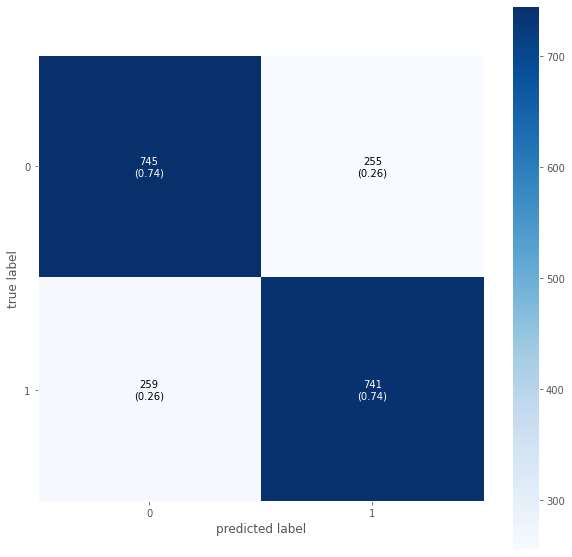

In [ ]:
print('\n')
print("Confusion Matrix")
print('\n')
CR = confusion_matrix(Y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR, figsize=(10,10),  show_absolute=True, show_normed=True, colorbar=True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier    
clf=RandomForestClassifier(n_estimators=50)
clf.fit(X_train,Y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
pred2 = clf.predict(X_test)
pred2 = (pred2 > 0.5)
print(pred2)
from sklearn import metrics
score2 = metrics.accuracy_score(Y_test, pred2)
print("Accuracy of RandomForest on test data is:", score2)

[False  True False ... False False False]
Accuracy of RandomForest on test data is: 0.5845




Confusion Matrix


[[651 349]
 [482 518]]




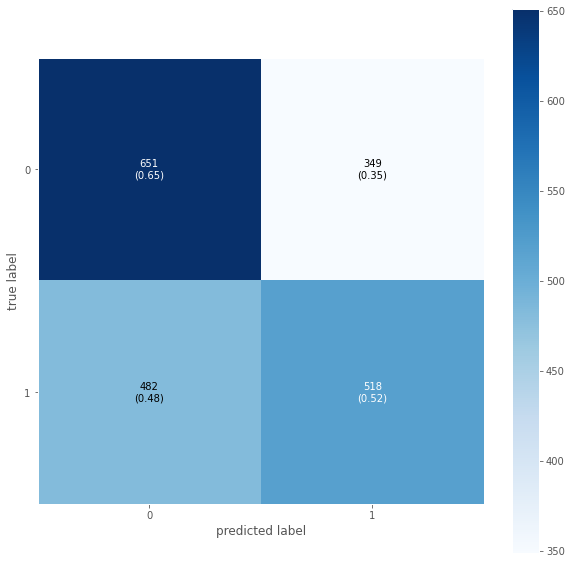

In [ ]:
print('\n')
print("Confusion Matrix")
print('\n')
CR = confusion_matrix(Y_test, pred2)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR, figsize=(10,10),  show_absolute=True, show_normed=True, colorbar=True)

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

In [ ]:
from keras.layers import LeakyReLU
model3 = Sequential()
model3.add(Dense(300, input_dim=500, activation='relu'))
model3.add(LeakyReLU(alpha=0.05))
model3.add(Dense(320, activation='relu'))
model3.add(LeakyReLU(alpha=0.05))
model3.add(Dense(240, activation='relu'))
model3.add(Dense(1,activation='sigmoid'))

model3.compile(Adam(lr=0.01), loss = "binary_crossentropy", metrics = ['accuracy'])

print(model3.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 300)               150300    
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 300)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 320)               96320     
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, 320)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 240)               77040     
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 241       
Total params: 323,901
Trainable params: 323,901
Non-trainable params: 0
_______________________________________________

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.2, random_state=2)

X_train=np.asarray(X_train).astype(np.float32)

Y_train=np.asarray(Y_train).astype(np.float32)

X_test=np.asarray(X_test).astype(np.float32)

Y_test=np.asarray(Y_test).astype(np.float32)

history = model3.fit(X_train, Y_train, validation_split= 0.10, epochs = 50, verbose = 1, batch_size= 100)

Epoch 1/50
72/72 [==============================] - 1s 11ms/step - loss: 10.7395 - accuracy: 0.5019 - val_loss: 0.7009 - val_accuracy: 0.5088
Epoch 2/50
72/72 [==============================] - 1s 9ms/step - loss: 0.7007 - accuracy: 0.5135 - val_loss: 0.7068 - val_accuracy: 0.4837
Epoch 3/50
72/72 [==============================] - 1s 9ms/step - loss: 0.7022 - accuracy: 0.5018 - val_loss: 0.7066 - val_accuracy: 0.4863
Epoch 4/50
72/72 [==============================] - 1s 9ms/step - loss: 0.6956 - accuracy: 0.5093 - val_loss: 0.6937 - val_accuracy: 0.4988
Epoch 5/50
72/72 [==============================] - 1s 8ms/step - loss: 0.6959 - accuracy: 0.5089 - val_loss: 0.6947 - val_accuracy: 0.5025
Epoch 6/50
72/72 [==============================] - 1s 9ms/step - loss: 0.6933 - accuracy: 0.5153 - val_loss: 0.7182 - val_accuracy: 0.4787
Epoch 7/50
72/72 [==============================] - 1s 9ms/step - loss: 0.7013 - accuracy: 0.5171 - val_loss: 0.6939 - val_accuracy: 0.5125
Epoch 8/50
72/72 [

In [ ]:
score3 = model3.evaluate(X_test, Y_test, verbose=0)
print("The accuracy of the ANN Model on test data is:",score3[1])

The accuracy of the ANN Model on test data is: 0.5034999847412109


In [ ]:
pred3 = model3.predict(X_test)
pred3 = (pred3 > 0.5)



Confusion Matrix


[[966  34]
 [959  41]]




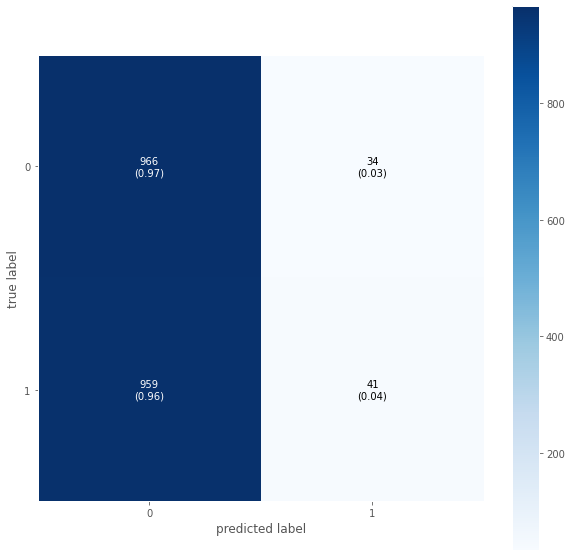

In [ ]:
print('\n')
print("Confusion Matrix")
print('\n')
CR = confusion_matrix(Y_test, pred3)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR, figsize=(10,10),  show_absolute=True, show_normed=True, colorbar=True)

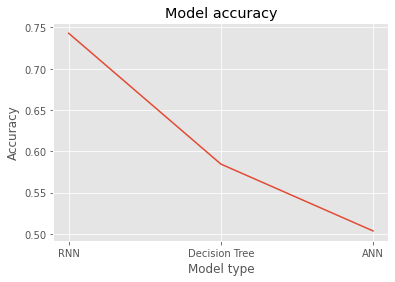

In [ ]:
plt.plot(['RNN', 'Decision Tree', 'ANN'], [score1[1], score2, score3[1]])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Model type')
#plt.legend(['Model Type', 'Accuracy'], loc='upper left')
plt.show()